In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision import models

from datasets import ImagenetDataset
from fooling_model import VGG16FoolingModel, VGG19FoolingModel, ResNet50FoolingModel
from utils import for_imagenet, power_method, process_image

In [5]:
def plot_examples(model, train_batch, val_batch, p=np.inf, q=10.0):
    orig_output = model.full_forward(for_imagenet(val_batch)).cpu()
    orig_probs, orig_preds = torch.softmax(orig_output, 1).max(1)
    
    nrows = len(model.LAYERS_IDS)
    ncols = 3
    plt.figure(figsize=(5*ncols, 5*nrows))
    plot_idx = 1
    for layer_name, layer_id in fooling_model.LAYERS_IDS:
        matvec, matvec_T = model.get_matvecs(train_batch, layer_id)
        perturb, _ = power_method(init, matvec, matvec_T, p=p, q=q, max_iter=20)
        normed_perturb = perturb.view(3, 224, 224) / torch.norm(perturb, p) * MAX_PERTURB_NORM
        
        perturb_output = model.full_forward(for_imagenet(val_batch + normed_perturb)).cpu()
        perturb_probs, perturb_preds = torch.softmax(perturb_output, 1).max(1)
        
        plt.subplot(nrows, ncols, plot_idx)
        plt.title('{}'.format(layer_name))
        plt.imshow(process_image(normed_perturb))
        plot_idx += 1
        
        plt.subplot(nrows, ncols, plot_idx)
        rand_idx = np.random.randint(val_batch.shape[0])
        pred, pred_name, pred_prob = orig_preds[rand_idx], idx2name[orig_preds[rand_idx].item()], orig_probs[rand_idx].item()
        plt.title('class #{} ({}), p={:.2f}'.format(pred, pred_name, pred_prob))
        plt.imshow(process_image(val_batch[rand_idx].cpu()))
        plot_idx += 1
        
        plt.subplot(nrows, ncols, plot_idx)
        pred, pred_name, pred_prob = perturb_preds[rand_idx], idx2name[perturb_preds[rand_idx].item()], perturb_probs[rand_idx].item()
        plt.title('class #{} ({}), p={:.2f}'.format(pred, pred_name, pred_prob))
        plt.imshow(process_image(val_batch[rand_idx] + normed_perturb).cpu())
        plot_idx += 1
    plt.show()

In [3]:
MAX_PERTURB_NORM = 10
p = np.inf
q = 10.0

class_index = json.load(open('imagenet_class_index.json'))
idx2name = {
    int(key): value[1]
    for key, value in class_index.items()
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

imgs_dir = 'imgs'
imgs_paths = [os.path.join(imgs_dir, img_name) for img_name in os.listdir(imgs_dir)]
dataset = ImagenetDataset(imgs_paths, device)
train_samples = dataset[:50]
val_samples = dataset[50:100]

init = torch.rand(3 * 224 * 224, device=device) - 0.5

VGG16


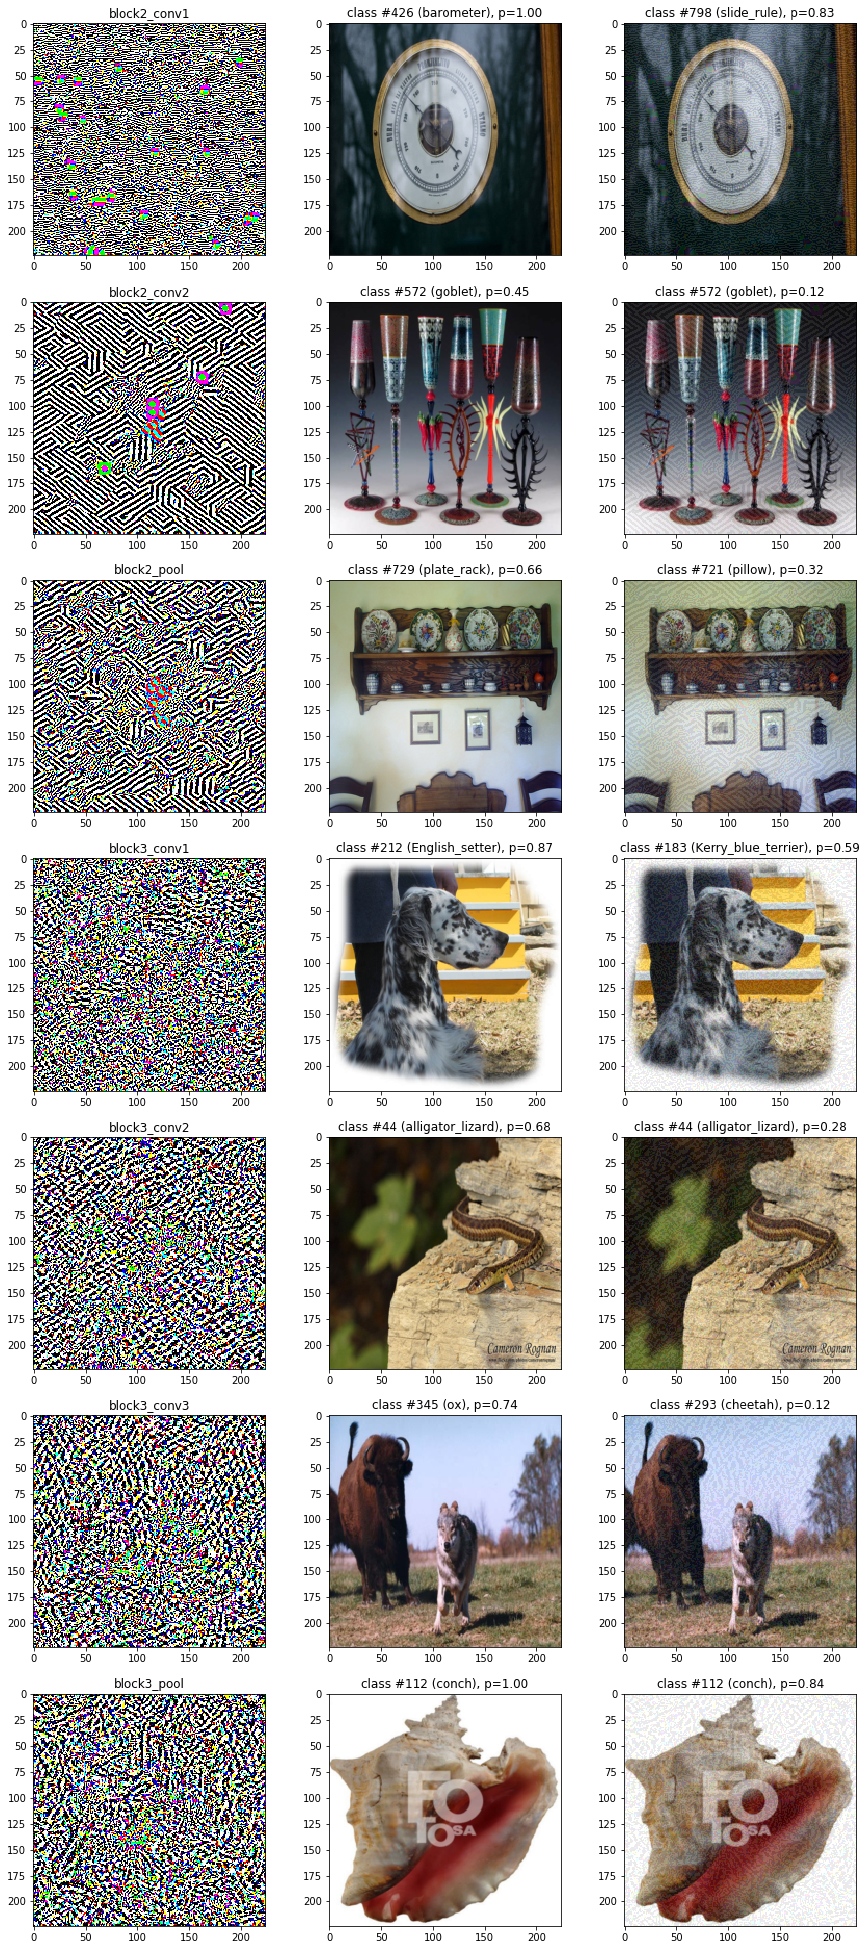

In [6]:
fooling_model = VGG16FoolingModel(models.vgg16(pretrained=True)).to(device)
fooling_model.eval();

print('VGG16')
plot_examples(fooling_model, train_samples, val_samples)

VGG19


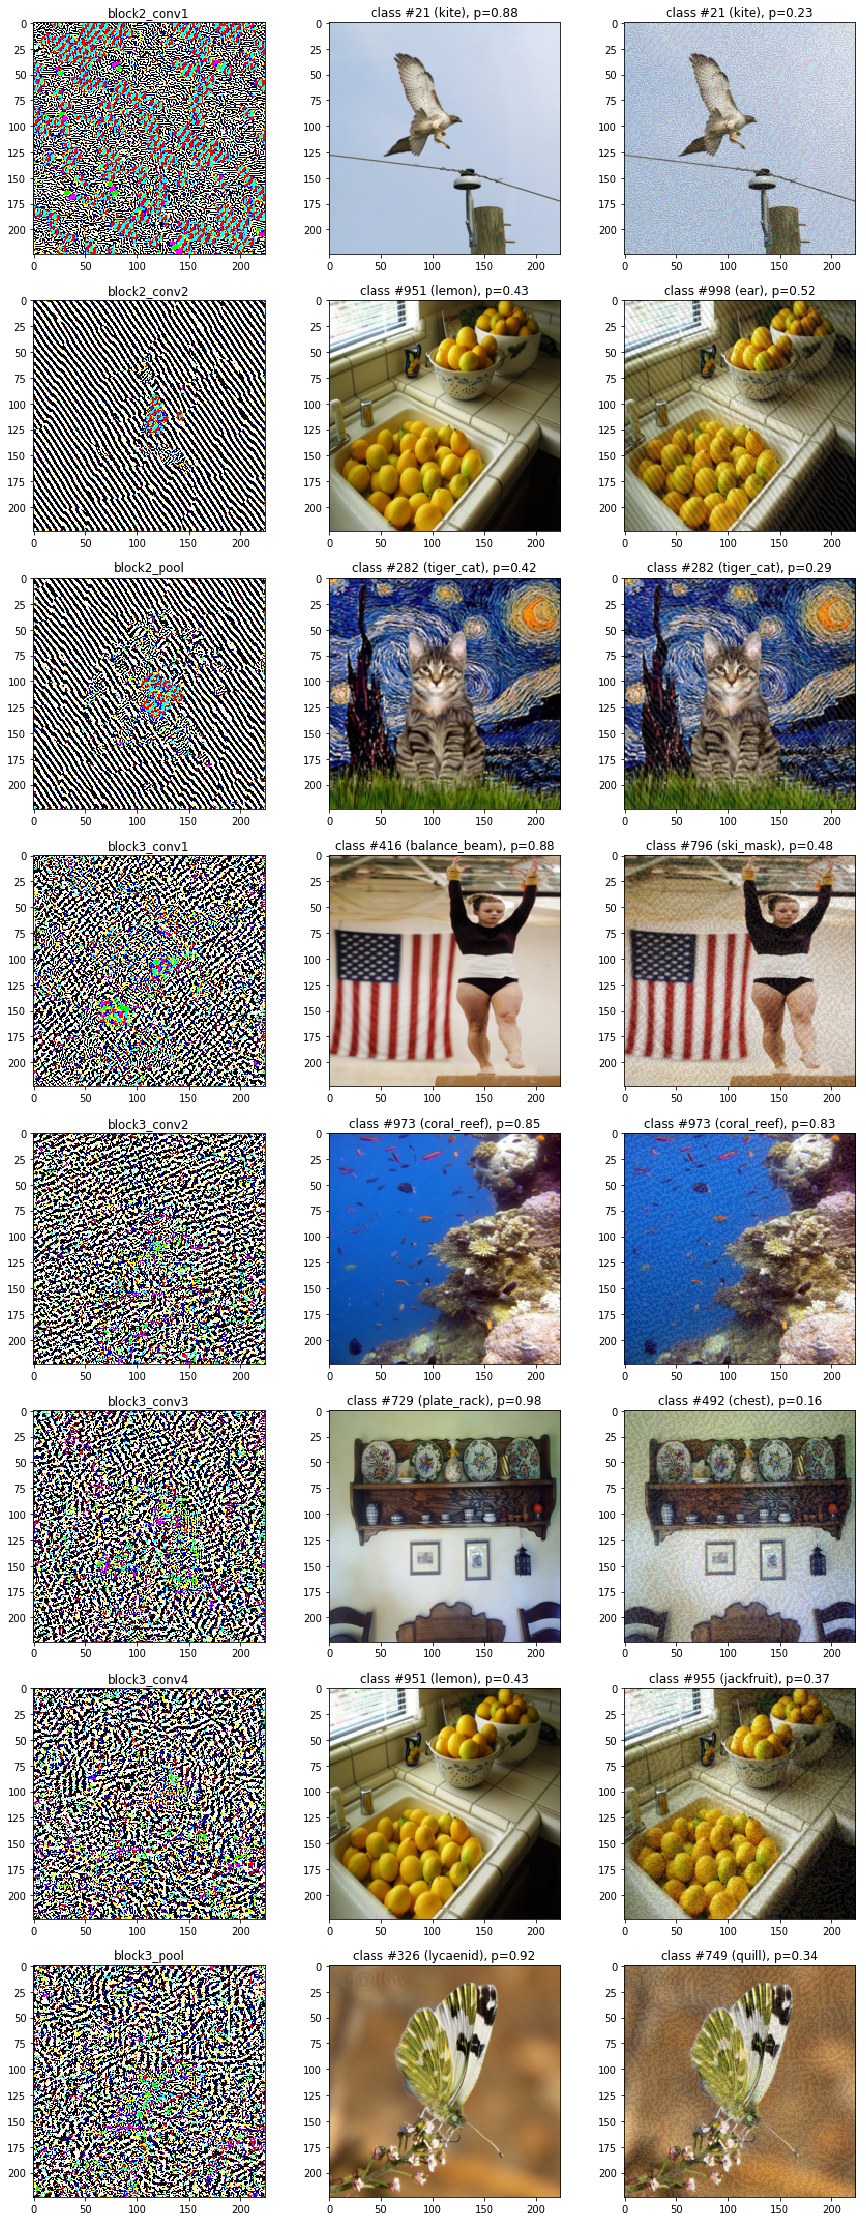

In [7]:
fooling_model = VGG19FoolingModel(models.vgg19(pretrained=True)).to(device)
fooling_model.eval();

print('VGG19')
plot_examples(fooling_model, train_samples, val_samples)

ResNet50


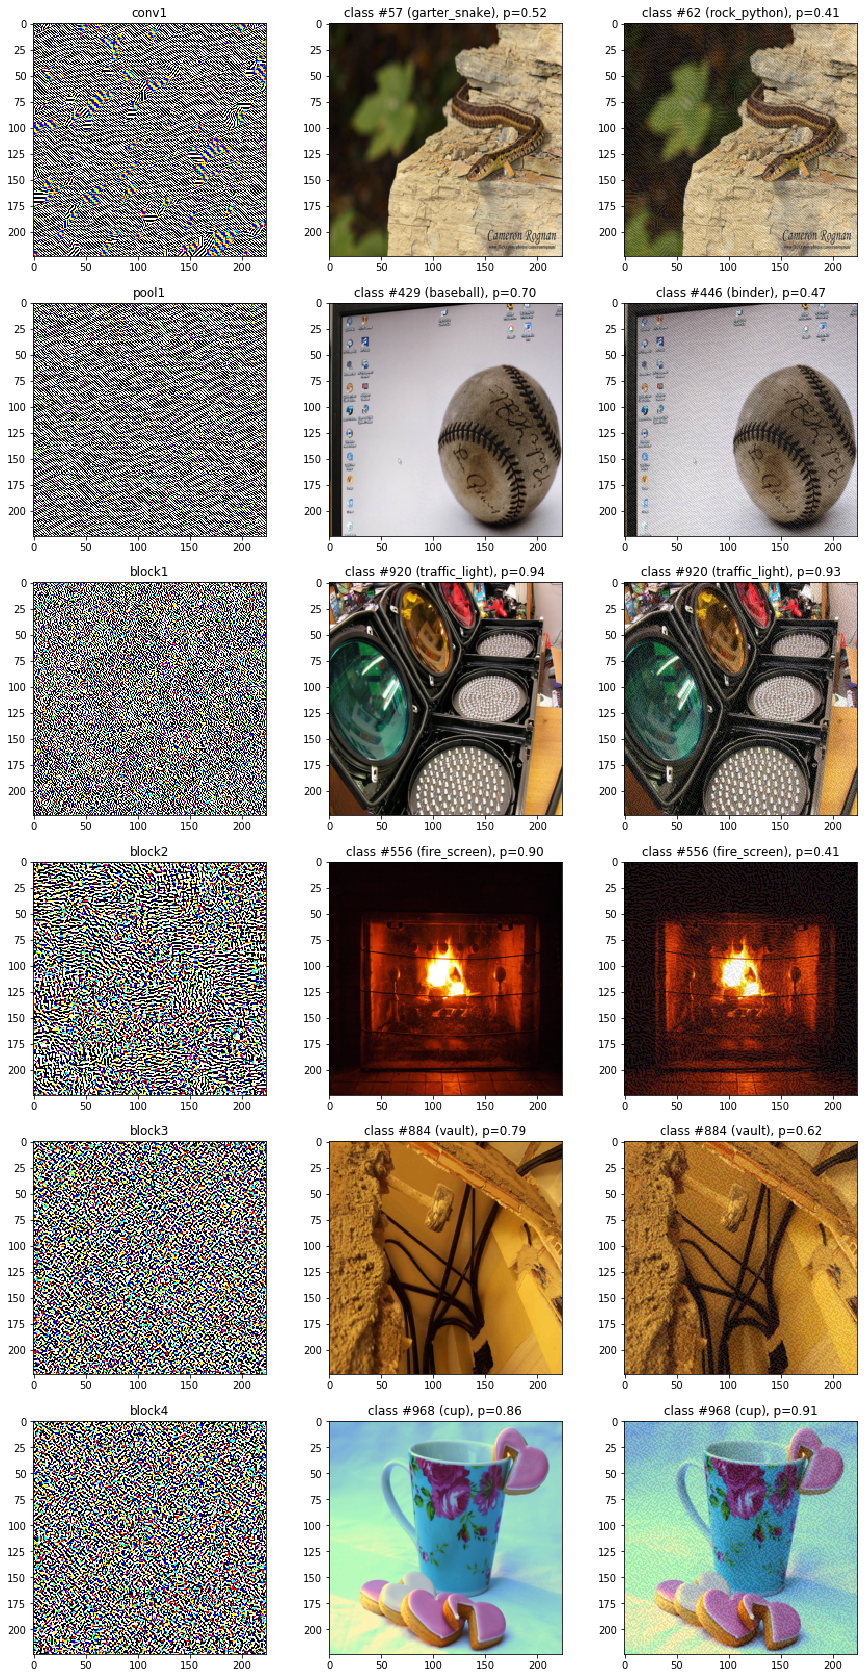

In [8]:
fooling_model = ResNet50FoolingModel(models.resnet50(pretrained=True)).to(device)
fooling_model.eval();

print('ResNet50')
plot_examples(fooling_model, train_samples, val_samples)